# Re-Double-checking FiveThirtyEight's 2016 Primary Predictions


## Loading the data

Load the data about their predictions and the actual outcomes into `pandas` dataframes:

In [1]:
# Load the dataframes from disk
import pandas as pd
dem = pd.read_csv("./2016_dem_primary_dataframe.csv", index_col=[0,1])
gop = pd.read_csv("./2016_gop_primary_dataframe.csv", index_col=[0,1])

In [2]:
# We only care about races where there was a prediction made
dem = dem.dropna()
gop = gop.dropna()

## Checking the intervals

Now I'll add a set of columns that tells us if the prediction was good or not, that is, if the actual result was within the 80% confidence interval or not:

In [3]:
import numpy as np

def add_good_predicitons(df, name="Prediction Good"):
    cond = (df['80% Lower Bound'] <= df['Result']) & (df["Result"] <= df["80% Upper Bound"])
    df["Prediction Good"] = np.where(cond, True, False)
    df["Prediction Low"] = np.where(df["80% Upper Bound"] < df["Result"], True, False)
    df["Prediction High"] = np.where(df["Result"] < df["80% Lower Bound"], True, False)

In [4]:
add_good_predicitons(dem)
add_good_predicitons(gop)

In [5]:
def add_scaled_result(df):
    interval = (df["80% Upper Bound"] - df["80% Lower Bound"]) / 2.
    means = df["80% Lower Bound"] + interval
    # The - out front makes it so that if the prediction is 1 sigma high, we get a +1
    df["Scaled Result"] = -(df["Result"] - means) / interval

In [6]:
add_scaled_result(dem)
add_scaled_result(gop)

## Seperate out the candidates

In [7]:
sanders = dem.xs("Sanders", level=1)
clinton = dem.xs("Clinton", level=1)
trump   = gop.xs("Trump", level=1)
rubio   = gop.xs("Rubio", level=1)
cruz    = gop.xs("Cruz", level=1)
carson  = gop.xs("Carson", level=1)

In [8]:
# Compute how the results match the predictions
def get_low_right_high(df):
    r = df["Prediction Good"]
    right = float(r.sum()) / r.count()
    h = df["Prediction High"]
    high = float(h.sum()) / h.count()
    l = df["Prediction Low"]
    low = float(l.sum()) / l.count()
    
    return low, right, high

In [9]:
sanders_low, sanders_right, sanders_high = get_low_right_high(sanders)
clinton_low, clinton_right, clinton_high = get_low_right_high(clinton)
cruz_low, cruz_right, cruz_high = get_low_right_high(cruz)
carson_low, carson_right, carson_high = get_low_right_high(carson)
trump_low, trump_right, trump_high = get_low_right_high(trump)
rubio_low, rubio_right, rubio_high = get_low_right_high(rubio)

In [10]:
print "Candidate         Under   Right   Over   Total"
print "----------|-------------------------------"
print "Clinton   | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(clinton_low, clinton_right, clinton_high, sum((clinton_low, clinton_right, clinton_high)))
print "Sanders   | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(sanders_low, sanders_right, sanders_high, sum((sanders_low, sanders_right, sanders_high)))
print "----------|-------------------------------"
print "Trump     | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(trump_low, trump_right, trump_high, sum((trump_low, trump_right, trump_high)))
print "Cruz      | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(cruz_low, cruz_right, cruz_high, sum((cruz_low, cruz_right, cruz_high)))
print "Rubio     | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(rubio_low, rubio_right, rubio_high, sum((rubio_low, rubio_right, rubio_high)))
print "Carson    | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(carson_low, carson_right, carson_high, sum((carson_low, carson_right, carson_high)))

Candidate         Under   Right   Over   Total
----------|-------------------------------
Clinton   | 0.00%, 74.07%, 25.93%, 100.00%
Sanders   | 7.41%, 88.89%, 3.70%, 100.00%
----------|-------------------------------
Trump     | 7.41%, 85.19%, 7.41%, 100.00%
Cruz      | 18.52%, 59.26%, 22.22%, 100.00%
Rubio     | 0.00%, 78.95%, 21.05%, 100.00%
Carson    | 0.00%, 100.00%, 0.00%, 100.00%


## Plotting the Results

We can make a plot of the actual voting results by scaling the vote share so that the low edge of the confidence interval is +1, the high edge is -1, and the midpoint is 0. Then if a candidate's vote share is within the predicted range their result will be between -1 and 1. If the prediction was 45% to 55% and the candidate actually got 60%, that would show up at -2 on the plot. The minus sign indicates that the prediction was too low.

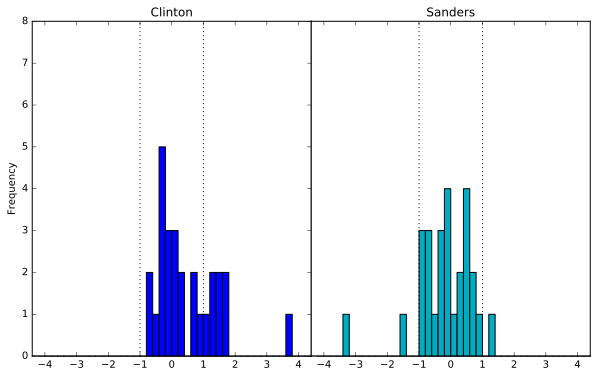

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

width = 10
height = 6

plt.figure(figsize=(width, height))

bins = [float(i)/10. for i in range(-44, 46, 2)]
ylim = [0, 8]
xlim = [min(bins), -min(bins)]


ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

clinton["Scaled Result"].plot(kind="hist", color='b', ax=ax1, ylim=ylim, xlim=xlim, bins=bins)
sanders["Scaled Result"].plot(kind="hist", color='#00acc1', ax=ax2, ylim=ylim, xlim=xlim, bins=bins)

# 80% Confidence intervals
color="black"
linestyle="dotted"
ax1.axvline(-1, color=color, linestyle=linestyle)
ax1.axvline(+1, color=color, linestyle=linestyle)
ax2.axvline(-1, color=color, linestyle=linestyle)
ax2.axvline(+1, color=color, linestyle=linestyle)

ax1.set_title("Clinton")
ax2.set_title("Sanders")
ax2.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0)

plt.savefig("/tmp/538_scaled_results_dem_by_candidate.png", bbox_inches='tight')
plt.savefig("/tmp/538_scaled_results_dem_by_candidate.svg", bbox_inches='tight')


plt.show()

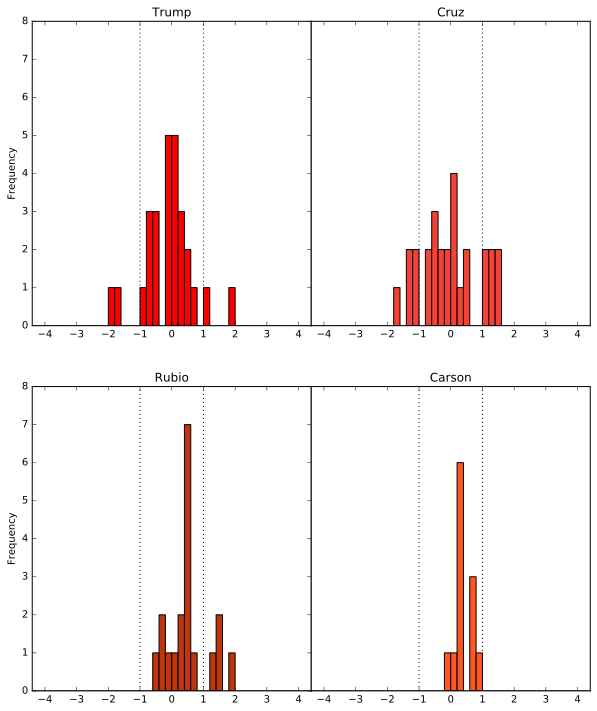

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

width = 10
height = 12

plt.figure(figsize=(width, height))

bins = [float(i)/10. for i in range(-44, 46, 2)]
ylim = [0, 8]
xlim = [min(bins), -min(bins)]


ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0))
ax4 = plt.subplot2grid((2,2),(1,1))

trump["Scaled Result"].plot(kind="hist", color='r', ax=ax1, ylim=ylim, xlim=xlim, bins=bins)
cruz["Scaled Result"].plot(kind="hist", color='#f44336', ax=ax2, ylim=ylim, xlim=xlim, bins=bins)
rubio["Scaled Result"].plot(kind="hist", color='#bf360c', ax=ax3, ylim=ylim, xlim=xlim, bins=bins)
carson["Scaled Result"].plot(kind="hist", color='#ff5722', ax=ax4, ylim=ylim, xlim=xlim, bins=bins)

# 80% Confidence intervals
color="black"
linestyle="dotted"
ax1.axvline(-1, color=color, linestyle=linestyle)
ax1.axvline(+1, color=color, linestyle=linestyle)
ax2.axvline(-1, color=color, linestyle=linestyle)
ax2.axvline(+1, color=color, linestyle=linestyle)
ax3.axvline(-1, color=color, linestyle=linestyle)
ax3.axvline(+1, color=color, linestyle=linestyle)
ax4.axvline(-1, color=color, linestyle=linestyle)
ax4.axvline(+1, color=color, linestyle=linestyle)

ax1.set_title("Trump")
ax2.set_title("Cruz")
ax2.yaxis.set_visible(False)

ax3.set_title("Rubio")
ax4.set_title("Carson")
ax4.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0)

plt.savefig("/tmp/538_scaled_results_gop_by_candidate.png", bbox_inches='tight')
plt.savefig("/tmp/538_scaled_results_gop_by_candidate.svg", bbox_inches='tight')

plt.show()

## Mean Absolute Miss Value

We now check, when the result is outside the confidence interval, how wrong is it on average?

In [13]:
def average_miss_value(df):
    vals = []
    for stuff in df.itertuples():
        scaled_value = abs(stuff[7])
        if scaled_value > 1:
            vals.append(scaled_value - 1)
            
    return np.mean(vals)

In [14]:
amv_clinton = average_miss_value(clinton)
amv_sanders = average_miss_value(sanders)
amv_trump   = average_miss_value(trump)
amv_cruz    = average_miss_value(cruz)
amv_rubio   = average_miss_value(rubio)
#amv_carson  = average_miss_value(carson) # Empty

In [15]:
print "Candidate   MAMV"
print "----------|----------------"
print "Clinton   | {:.2}".format(amv_clinton)
print "Sanders   | {:.2}".format(amv_sanders)
print "----------|----------------"
print "Trump     | {:.2}".format(amv_trump)
print "Cruz      | {:.2}".format(amv_cruz)
print "Rubio     | {:.2}".format(amv_rubio)

Candidate   MAMV
----------|----------------
Clinton   | 0.84
Sanders   | 1.0
----------|----------------
Trump     | 0.66
Cruz      | 0.28
Rubio     | 0.57


Now we remove Michigan for the Democrats to see how badly it is pulling the results.

In [16]:
def average_miss_value_no_mich(df):
    vals = []
    for stuff in df.itertuples():
        scaled_value = abs(stuff[7])
        if scaled_value > 1 and scaled_value < 3:
            vals.append(scaled_value - 1)
            
    return np.mean(vals)

In [17]:
amv_clinton_no_mich = average_miss_value_no_mich(clinton)
amv_sanders_no_mich = average_miss_value_no_mich(sanders)

In [18]:
print "Candidate   MAMV with MI"
print "----------|----------------"
print "Clinton   | {:.2}".format(amv_clinton_no_mich)
print "Sanders   | {:.2}".format(amv_sanders_no_mich)


Candidate   MAMV with MI
----------|----------------
Clinton   | 0.52
Sanders   | 0.39
